In [13]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import quad_vec
from tqdm import tqdm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 200,
})


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


#Simulation Functions

In [14]:
def diffuse(dx,D,Q_prev):
  Q_temp = np.pad(Q_prev,(1,1),'edge') #Assumes von Neumann BCs, for Dirichlet use e.g. np.pad(Q_prev,(1,1),'constant', constant_values=(0, 0))
  gradient = D*np.diff(Q_temp)/dx
  return (-gradient[:-1]+gradient[1:])/dx

def forwardeuler_step(dt,dx,D,R,Q0,Q_prev):
  Q_next=Q_prev.copy()
  # simple terms
  Q_next -= dt*R*(Q_prev**2+2*Q0*Q_prev)
  # diffusion
  Q_next += dt*diffuse(dx,D,Q_prev)
  return Q_next

def rhs_estimate(dx,D,R,Q0,Q_prev):
  rhs=np.zeros_like(Q_prev)
  # simple terms
  rhs -= R*(Q_prev**2+2*Q0*Q_prev)
  # diffusion
  rhs += diffuse(dx,D,Q_prev)
  return rhs

def RK4_step(dt,dx,D,R,Q0,Q_prev):
  k1 = rhs_estimate(dx,D,R,Q0,Q_prev)
  k2 = rhs_estimate(dx,D,R,Q0,Q_prev+k1*dt/2)
  k3 = rhs_estimate(dx,D,R,Q0,Q_prev+k2*dt/2)
  k4 = rhs_estimate(dx,D,R,Q0,Q_prev+k3*dt)
  Q_next = Q_prev + (k1+2*k2+2*k3+k4)*dt/6
  return Q_next

def backwardeuler_eqs(dt,dx,D,R,Q0,Q_prev,Q_next):
  return Q_prev - Q_next + dt*(diffuse(dx,D,Q_next) - R*Q_next**2 - 2*R*Q0*Q_next)

def backwardeuler_step(dt,dx,D,R,Q0,Q_prev):
  return fsolve(lambda Q_next : backwardeuler_eqs(dt,dx,D,R,Q0,Q_prev,Q_next), RK4_step(dt/1000,dx,D,R,Q0,Q_prev))

def CN_eqs(dt,dx,D,R,Q0,Q_prev,Q_next):
  return Q_prev - Q_next + 0.5*dt*(diffuse(dx,D,Q_next) - R*Q_next**2 - 2*R*Q0*Q_next +
                                   diffuse(dx,D,Q_prev) - R*Q_prev**2 - 2*R*Q0*Q_prev)

def CN_step(dt,dx,D,R,Q0,Q_prev):
  return fsolve(lambda Q_next : CN_eqs(dt,dx,D,R,Q0,Q_prev,Q_next), RK4_step(dt/1000,dx,D,R,Q0,Q_prev))

def simulate(Q_start,steps,dt,dx,D,R,Q0,method='BackwardEuler'):
  if method == 'RK4':
    step = RK4_step
  elif method == 'ForwardEuler':
    step = forwardeuler_step
  elif method == 'BackwardEuler':
    step = backwardeuler_step
  elif method == 'CrankNicolson':
    step = CN_step
  else:
    raise ValueError('Invalid option')

  Q_list=np.zeros((steps+1,len(Q_start)))
  Q_list[0,:]=Q_start
  for i in tqdm(range(steps)):
    Q_list[i+1,:]=step(dt,dx,D,R,Q0,Q_list[i,:])
  return Q_list

#Analytical functions

In [3]:
# perturbation from 1/t solution

def Q_no_dif(Q_init,R,Q0,t):
  return 2*Q0/((2*Q0/Q_init+1)*np.exp(2*Q0*R*t)-1)

def integrand_D_general(x_axis,Q_init,R,Q0,t):
  return np.exp(-2*R*Q0*t)*(((2*Q0+Q_init)*np.exp(2*Q0*R*t)-Q_init)/(2*Q0))**2*np.gradient(np.gradient(Q_no_dif(Q_init,R,Q0,t),x_axis),x_axis)

def perturbation_D(x_axis,Q_init,D,R,Q0,t):
  return D*np.exp(2*R*Q0*t)*(((2*Q0+Q_init)*np.exp(2*Q0*R*t)-Q_init)/(2*Q0))**(-2)*quad_vec(lambda t0: integrand_D_general(x_axis,Q_init,R,Q0,t0),0,t)[0]

#Tests

In [24]:
#bTa

R=0.0034193
Q0=1.4623
N_init=14963
D_all=1
sigma_init=5

# define geometry
dt=0.05
dx=0.5
L=90 # make sure dx cleanly divides L
N=int(L/dx)
x_borders=np.linspace(-L/2,L/2,N,endpoint=True)
x_centers=np.linspace(-L/2+dx,L/2-dx,N-1,endpoint=True)
D=np.ones_like(x_borders)*D_all

# IC
Q_init = np.exp(-0.5*(x_centers/sigma_init)**2)*N_init/(sigma_init*np.sqrt(2*np.pi))
#Q_init = (np.abs(x_centers) < sigma_init)*N_init/(2*sigma_init)
print(np.sum(Q_init)*dx)

# Simulation
T=300
t_axis_bTa = np.arange(0,T+dt,dt)
Q_list_bTa = simulate(Q_init,int(T/dt),dt,dx,D_all,R,Q0,method='CrankNicolson')

14963.000000000002


100%|██████████| 6000/6000 [03:13<00:00, 30.93it/s]


In [25]:
# No dif
Q_list_nodif = np.zeros((len(t_axis_bTa),len(Q_init)))
for i,t in enumerate(tqdm(t_axis_bTa)):
  Q_list_nodif[i,:] = Q_no_dif(Q_init,R,Q0,t)
# Pert dif
Q_list_pertD = np.zeros((len(t_axis_bTa),len(Q_init)))
for i,t in enumerate(tqdm(t_axis_bTa)):
  Q_list_pertD[i,:] = perturbation_D(x_centers,Q_init,D_all,R,Q0,t)

Q_list_correctedD = Q_list_nodif + Q_list_pertD

100%|██████████| 6001/6001 [04:05<00:00, 24.48it/s]


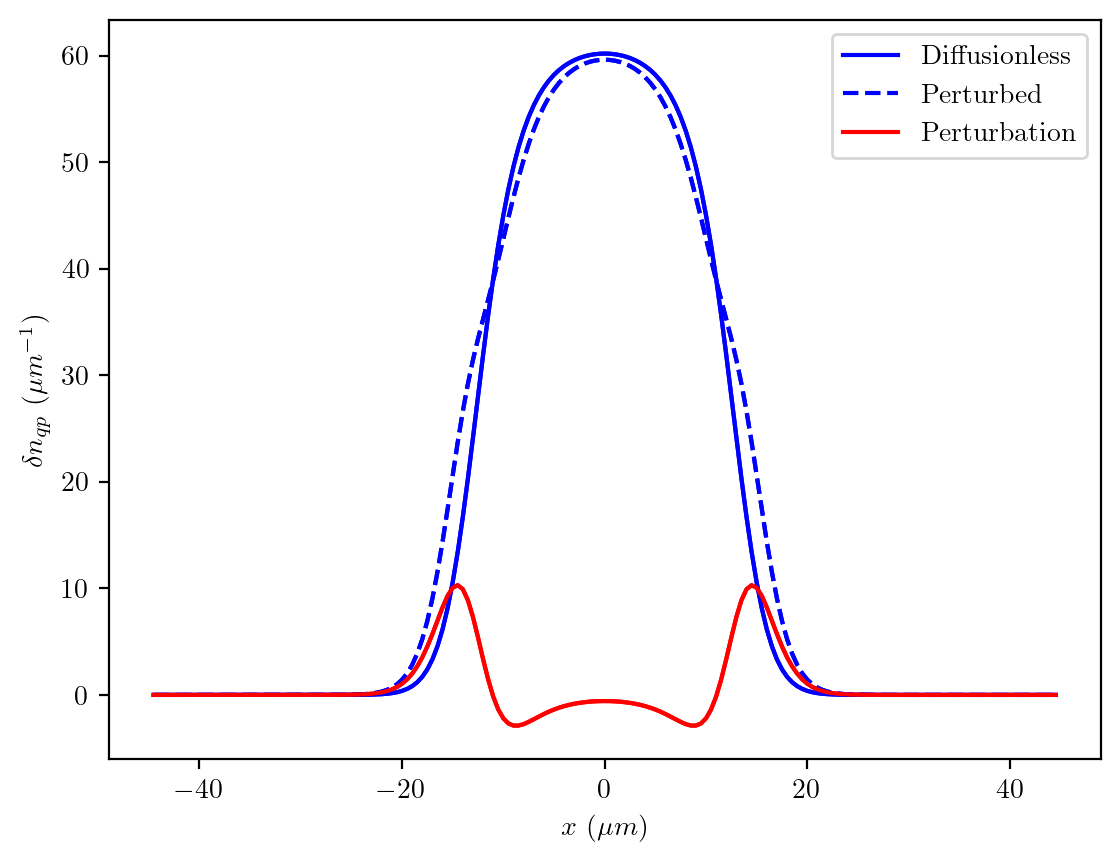

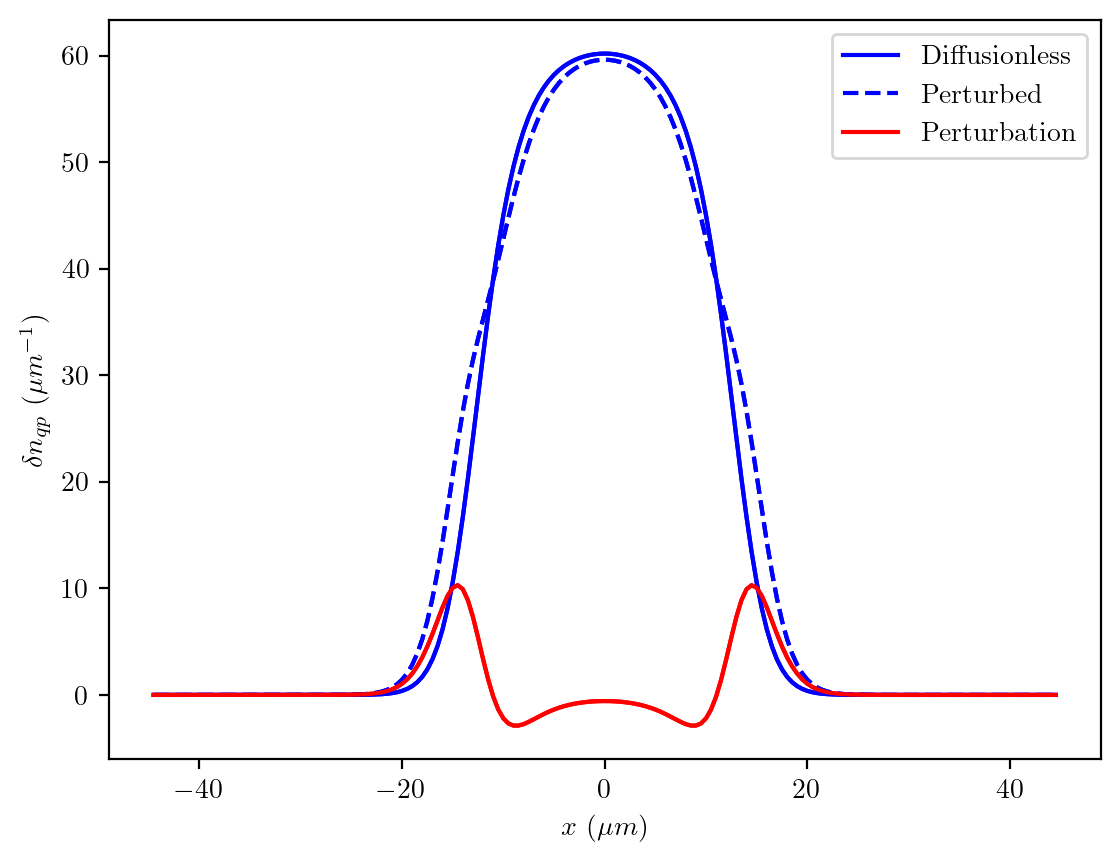

In [36]:
for i,t in list(enumerate(t_axis_bTa))[90:91:100]:
  plt.plot(x_centers,Q_list_nodif[i],color='b')
  plt.plot(x_centers,Q_list_correctedD[i],color='b',ls='--')
  plt.plot(x_centers,Q_list_pertD[i],color='r')
plt.plot(x_centers,Q_list_nodif[i],color='b',label='Diffusionless')
plt.plot(x_centers,Q_list_correctedD[i],color='b',ls='--',label='Perturbed')
plt.plot(x_centers,Q_list_pertD[i],color='r',label='Perturbation')
plt.ylabel('$\delta n_{qp}$ ($\mu m^{-1}$)')
plt.xlabel('$x$ ($\mu m$)')
plt.legend()


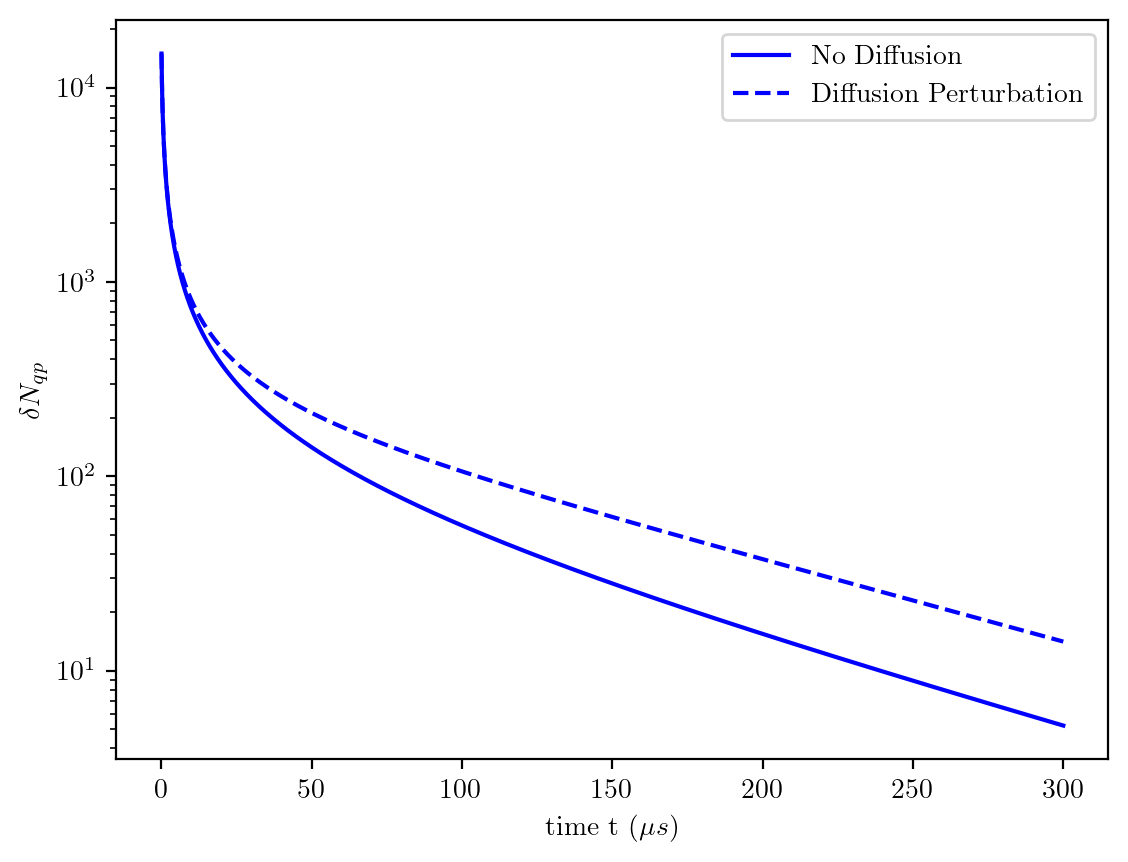

In [37]:
intQ_bTa_list = np.sum(Q_list_bTa*dx,axis=1)
intQ_nodif_list = np.sum(Q_list_nodif*dx,axis=1)
intQ_pertD_list = np.sum(Q_list_correctedD*dx,axis=1)

#plt.semilogy(t_axis_bTa,intQ_bTa_list,color='g',label=r'Full equation')
plt.semilogy(t_axis_bTa,intQ_nodif_list,color='b',label=r'No Diffusion')
plt.semilogy(t_axis_bTa,intQ_pertD_list,color='b',ls='--',label=r'Diffusion Perturbation')
plt.xlabel(r'time t ($\mu s$)')
plt.ylabel(r'$\delta N_{qp}$')
plt.legend()

In [28]:
# bTa short time scale

intQ_bTa_list = np.sum(Q_list_bTa*dx,axis=1)
intQ_nodif_list = np.sum(Q_list_nodif*dx,axis=1)
intQ_pertD_list = np.sum(Q_list_corrected*dx,axis=1)

plt.semilogy(t_axis_bTa,intQ_bTa_list,color='r',label=r'Full equation')
plt.semilogy(t_axis_bTa,intQ_nodif_list,color='b',label=r'No Diffusion')
plt.semilogy(t_axis_bTa,intQ_pertD_list,color='g',label=r'Diffusion perturbation')
plt.xlabel(r'time t ($\mu s$)')
plt.ylabel(r'$\delta N_{qp}$')
plt.xlim(0,0.01)
plt.legend()

NameError: name 'Q_list_corrected' is not defined